In [33]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from sklearn.model_selection import StratifiedKFold


## 1. 데이터 불러오기

In [34]:
# 학습용과 평가용 데이터를 읽기
train = pd.read_csv('X_train.csv', encoding='cp949')
test = pd.read_csv('X_test.csv', encoding='cp949')

# 분석에 필요없는 SEQ열 삭제, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 따로 보관
train_SEQ = train['SEQ']
test_SEQ = test['SEQ']
del train['SEQ'], test['SEQ']

# 학습요 정답 데이터 가져오기
y_train = pd.read_csv('y_train.csv', encoding='cp949').매칭성공여부

# 동일한 전처리를 위해 학습용 데이터와 평가용 데이터 합치기
features = pd.concat([train, test]).reset_index(drop=True)
features

,서비스이용시간,매니저나이,부재중서비스매칭,서비스요청요일,서비스요청계절,반려동물여부,우선청소여부,주소매칭여부,미리예약,가입기간,현재회차,CS교육이수여부,청소교육이수여부
0,4,65,0,평일,여름,0,0,0,20,78.0,3,0.0,0.0
1,6,45,0,평일,여름,0,0,1,39,52.0,3,1.0,1.0
2,4,51,1,평일,겨울,0,0,1,23,35.0,6,0.0,0.0
3,5,65,0,평일,가을,0,1,1,21,277.0,4,0.0,0.0
4,4,55,0,평일,봄,0,0,1,42,158.0,2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27248,4,60,0,평일,가을,0,1,1,7,228.0,1,0.0,0.0
27249,4,45,0,평일,겨울,0,0,1,6,-6.0,1,0.0,0.0
27250,4,60,0,평일,겨울,0,1,1,7,609.0,1,0.0,0.0
27251,4,57,0,평일,겨울,0,0,1,49,196.0,6,0.0,0.0


## 2. Data Cleansing & Feature Engineering

In [35]:
# 범주형 변수와 수치형 변수를 분리
cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list() 

In [36]:
# 수치형 변수를 정규분포에 가깝게 만들기
features[num_features] = PowerTransformer(standardize=True).fit_transform(features[num_features])
features

,서비스이용시간,매니저나이,부재중서비스매칭,서비스요청요일,서비스요청계절,반려동물여부,우선청소여부,주소매칭여부,미리예약,가입기간,현재회차,CS교육이수여부,청소교육이수여부
0,0.156206,1.824058,-0.548393,평일,여름,-0.430494,-0.980630,-1.339629,0.511141,0.013325,0.882026,-0.453745,-0.491695
1,2.549605,-1.237119,-0.548393,평일,여름,-0.430494,-0.980630,0.746475,1.522946,-0.164052,0.882026,2.203879,2.033780
2,0.156206,-0.458846,1.823509,평일,겨울,-0.430494,-0.980630,0.746475,0.705172,-0.297553,1.752481,-0.453745,-0.491695
3,1.426868,1.824058,-0.548393,평일,가을,-0.430494,1.019753,0.746475,0.577864,0.989018,1.285355,-0.453745,-0.491695
4,0.156206,0.125776,-0.548393,평일,봄,-0.430494,-0.980630,0.746475,1.649110,0.458226,0.218171,-0.453745,-0.491695
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27248,0.156206,0.932147,-0.548393,평일,가을,-0.430494,1.019753,0.746475,-0.683533,0.782878,-1.086998,-0.453745,-0.491695
27249,0.156206,-1.237119,-0.548393,평일,겨울,-0.430494,-0.980630,0.746475,-0.823406,-1.015372,-1.086998,-0.453745,-0.491695
27250,0.156206,0.932147,-0.548393,평일,겨울,-0.430494,1.019753,0.746475,-0.683533,2.144974,-1.086998,-0.453745,-0.491695
27251,0.156206,0.438163,-0.548393,평일,겨울,-0.430494,-0.980630,0.746475,1.921131,0.639657,1.752481,-0.453745,-0.491695


In [37]:
# 범주형 변수에 One-Hot-Encoding 후 수치형 변수와 병합
if len(cat_features) > 0:
    features = pd.concat([features[num_features], pd.get_dummies(features[cat_features])], axis=1)
features

,서비스이용시간,매니저나이,부재중서비스매칭,반려동물여부,우선청소여부,주소매칭여부,미리예약,가입기간,현재회차,CS교육이수여부,청소교육이수여부,서비스요청요일_주말,서비스요청요일_평일,서비스요청계절_가을,서비스요청계절_겨울,서비스요청계절_봄,서비스요청계절_여름
0,0.156206,1.824058,-0.548393,-0.430494,-0.980630,-1.339629,0.511141,0.013325,0.882026,-0.453745,-0.491695,0,1,0,0,0,1
1,2.549605,-1.237119,-0.548393,-0.430494,-0.980630,0.746475,1.522946,-0.164052,0.882026,2.203879,2.033780,0,1,0,0,0,1
2,0.156206,-0.458846,1.823509,-0.430494,-0.980630,0.746475,0.705172,-0.297553,1.752481,-0.453745,-0.491695,0,1,0,1,0,0
3,1.426868,1.824058,-0.548393,-0.430494,1.019753,0.746475,0.577864,0.989018,1.285355,-0.453745,-0.491695,0,1,1,0,0,0
4,0.156206,0.125776,-0.548393,-0.430494,-0.980630,0.746475,1.649110,0.458226,0.218171,-0.453745,-0.491695,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27248,0.156206,0.932147,-0.548393,-0.430494,1.019753,0.746475,-0.683533,0.782878,-1.086998,-0.453745,-0.491695,0,1,1,0,0,0
27249,0.156206,-1.237119,-0.548393,-0.430494,-0.980630,0.746475,-0.823406,-1.015372,-1.086998,-0.453745,-0.491695,0,1,0,1,0,0
27250,0.156206,0.932147,-0.548393,-0.430494,1.019753,0.746475,-0.683533,2.144974,-1.086998,-0.453745,-0.491695,0,1,0,1,0,0
27251,0.156206,0.438163,-0.548393,-0.430494,-0.980630,0.746475,1.921131,0.639657,1.752481,-0.453745,-0.491695,0,1,0,1,0,0


In [40]:
# 결측값 처리
features[num_features] = features[num_features].fillna(0)
#features[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(features[cat_features])
features

,SEQ,서비스이용시간,매니저나이,부재중서비스매칭,반려동물여부,우선청소여부,주소매칭여부,미리예약,가입기간,현재회차,CS교육이수여부,청소교육이수여부,서비스요청요일_주말,서비스요청요일_평일,서비스요청계절_가을,서비스요청계절_겨울,서비스요청계절_봄,서비스요청계절_여름
0,T06420,0.156206,1.824058,-0.548393,-0.430494,-0.980630,-1.339629,0.511141,0.013325,0.882026,-0.453745,-0.491695,0,1,0,0,0,1
1,T15430,2.549605,-1.237119,-0.548393,-0.430494,-0.980630,0.746475,1.522946,-0.164052,0.882026,2.203879,2.033780,0,1,0,0,0,1
2,T23790,0.156206,-0.458846,1.823509,-0.430494,-0.980630,0.746475,0.705172,-0.297553,1.752481,-0.453745,-0.491695,0,1,0,1,0,0
3,T18740,1.426868,1.824058,-0.548393,-0.430494,1.019753,0.746475,0.577864,0.989018,1.285355,-0.453745,-0.491695,0,1,1,0,0,0
4,T08451,0.156206,0.125776,-0.548393,-0.430494,-0.980630,0.746475,1.649110,0.458226,0.218171,-0.453745,-0.491695,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27248,T31589,0.156206,0.932147,-0.548393,-0.430494,1.019753,0.746475,-0.683533,0.782878,-1.086998,-0.453745,-0.491695,0,1,1,0,0,0
27249,T36236,0.156206,-1.237119,-0.548393,-0.430494,-0.980630,0.746475,-0.823406,-1.015372,-1.086998,-0.453745,-0.491695,0,1,0,1,0,0
27250,T34729,0.156206,0.932147,-0.548393,-0.430494,1.019753,0.746475,-0.683533,2.144974,-1.086998,-0.453745,-0.491695,0,1,0,1,0,0
27251,T53830,0.156206,0.438163,-0.548393,-0.430494,-0.980630,0.746475,1.921131,0.639657,1.752481,-0.453745,-0.491695,0,1,0,1,0,0


In [41]:
# 학습용과 제출용 데이터로 분리
features = pd.concat([pd.concat([train_SEQ, test_SEQ]).reset_index(drop=True), features], axis=1)
X_train = features.query('SEQ in @train_SEQ').drop('SEQ', axis=1)
X_test = features.query('SEQ in @test_SEQ').drop('SEQ', axis=1)

## 3. Model Tuning (Hyperparameter Optimization)

In [42]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

### LogisticRegression

In [50]:
clfs = [
    (
        KNeighborsClassifier(),              # 사용하려는 모델
        {'n_neighbors': [3,5,7,9,11],        # 최적화하려는 하이퍼파라미터
         'weights': ['uniform','distance']}
    ),
    (
        MLPClassifier(random_state=0),
        {'batch_size': ['auto', 32, 64, 128],
         'learning_rate' : ['constant', 'adaptive'],
         'activation': ['tanh', 'relu'],
         'solver': ['sgd', 'adam']}
    ),
    (
        LogisticRegression(random_state=0),  
        {'C': np.arange(0.1, 1.1, 0.1),      
         'penalty': ['l1','l2']}
    ),
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [300,400,500],
         'max_depth': [5,7,9,11],
        'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],
        'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
]

clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=5, scoring='roc_auc', 
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_dev, y_dev)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))


 20%|████████████████▊                                                                   | 1/5 [00:07<00:31,  7.83s/it]

KNeighborsClassifier                                 0.709546 7.8


 40%|█████████████████████████████████▌                                                  | 2/5 [00:54<01:32, 30.78s/it]

MLPClassifier                                        0.785391 46.8


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:54<00:33, 16.86s/it]

LogisticRegression                                   0.651259 0.3


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:17<00:18, 18.97s/it]

RandomForestClassifier                               0.841108 22.2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:21<00:00, 16.28s/it]

GradientBoostingClassifier                           0.779399 4.3


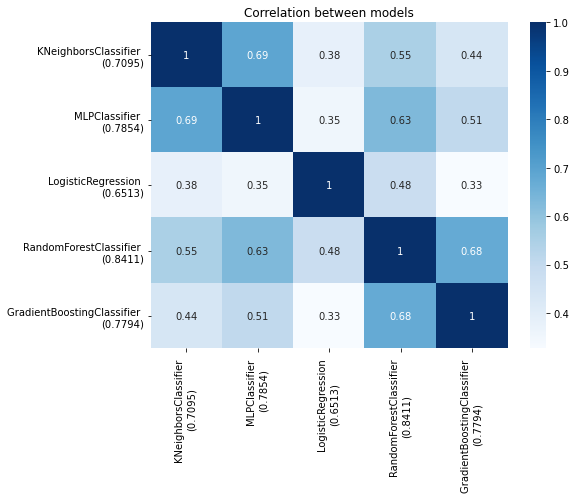

In [52]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

In [53]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

KNeighborsClassifier \n(0.7095)          0.516338
MLPClassifier \n(0.7854)                 0.545690
LogisticRegression \n(0.6513)            0.386968
RandomForestClassifier \n(0.8411)        0.585400
GradientBoostingClassifier \n(0.7794)    0.487072
dtype: float64

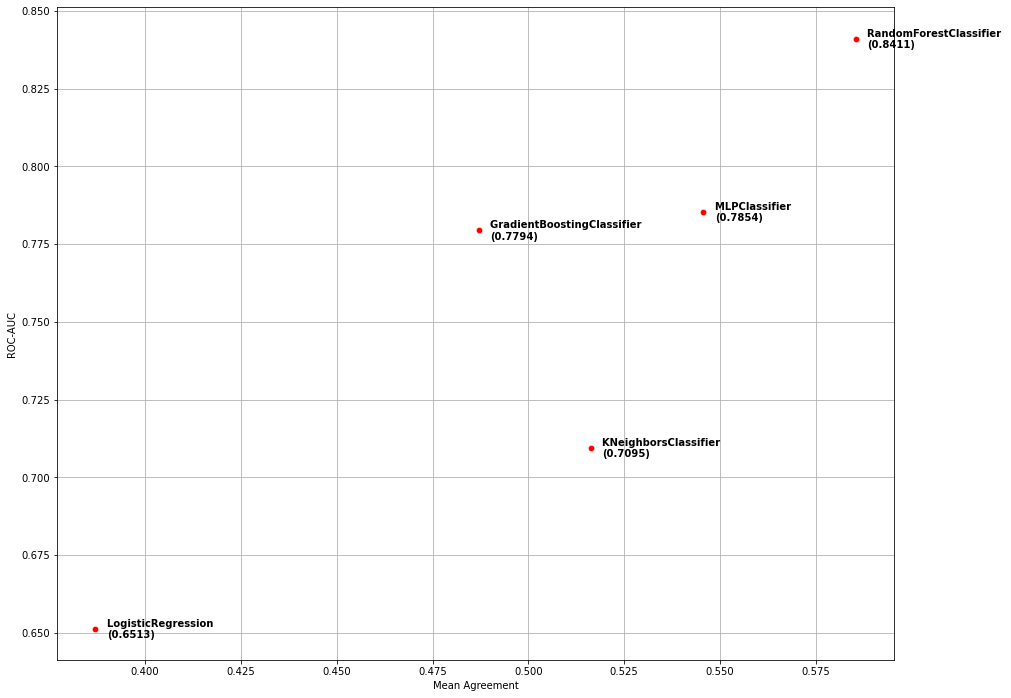

In [54]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(15,12))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

In [55]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하시오.
selected = [ 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',
    'XGBClassifier'
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [56]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(3, len(models_for_ensemble)+1): # 3개 이상의 모델이 앙상블된 것들 중 가장 성능이 좋은 것을 선택
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.56s/it]

p=1
MLPClassifier●LogisticRegression●RandomForestClassifier
0.8299131961827513


In [57]:
# sklearn의 다른 classifier와 호환성을 갖기위해 Custom Classifier인 "AveragingClassifier" 생성

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def fit(self, X, y):
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in estimators], axis=0)
        else:
            preds = [clf.predict(X) for name, clf in estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict_proba(X) for name, clf in estimators], axis=0)
        else:
            probs = [clf.predict_proba(X) for name, clf in estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(estimators))**(1/self.p)
        return prob
    
estimators = [(name, clf) for name, clf, _ in models]
avg_clf = AveragingClassifier(estimators, p)
avg_clf.fit(X_train, y_train)  

In [27]:
avg_clf.predict_proba(X_train)

array([[0.92194206, 0.07805794],
       [0.93071678, 0.06928322],
       [0.98851098, 0.01148902],
       ...,
       [0.98754709, 0.01245291],
       [0.94097517, 0.05902483],
       [0.8731443 , 0.1268557 ]])

In [26]:
avg_clf.predict_proba(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [59]:
pd.DataFrame({'SEQ': test_SEQ, 'pred': avg_clf.predict_proba(X_test)[:,1]}).to_csv('조기흠-submission-features.csv', index=False)

In [30]:
features.iloc[0:23009]

,SEQ,서비스이용시간,매니저나이,부재중서비스매칭,반려동물여부,우선청소여부,주소매칭여부,미리예약,가입기간,현재회차,CS교육이수여부,청소교육이수여부,서비스요청요일_주말,서비스요청요일_평일,서비스요청계절_가을,서비스요청계절_겨울,서비스요청계절_봄,서비스요청계절_여름
0,T06420,0.156206,1.824058,-0.548393,-0.430494,-0.980630,-1.339629,0.511141,0.013325,0.882026,-0.453745,-0.491695,0,1,0,0,0,1
1,T15430,2.549605,-1.237119,-0.548393,-0.430494,-0.980630,0.746475,1.522946,-0.164052,0.882026,2.203879,2.033780,0,1,0,0,0,1
2,T23790,0.156206,-0.458846,1.823509,-0.430494,-0.980630,0.746475,0.705172,-0.297553,1.752481,-0.453745,-0.491695,0,1,0,1,0,0
3,T18740,1.426868,1.824058,-0.548393,-0.430494,1.019753,0.746475,0.577864,0.989018,1.285355,-0.453745,-0.491695,0,1,1,0,0,0
4,T08451,0.156206,0.125776,-0.548393,-0.430494,-0.980630,0.746475,1.649110,0.458226,0.218171,-0.453745,-0.491695,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23004,T17071,-3.096869,-0.458846,1.823509,2.322911,1.019753,-1.339629,-1.896981,-0.248284,-1.086998,-0.453745,-0.491695,0,1,0,1,0,0
23005,T01336,0.156206,-0.317674,-0.548393,-0.430494,-0.980630,0.746475,4.034536,0.826137,2.108743,-0.453745,-0.491695,0,1,0,0,0,1
23006,T00544,0.156206,-0.596718,1.823509,-0.430494,-0.980630,-1.339629,1.846295,0.111971,0.882026,-0.453745,-0.491695,0,1,0,0,0,1
23007,T19297,0.156206,-0.025378,-0.548393,-0.430494,-0.980630,0.746475,0.219438,-0.674892,0.882026,2.203879,2.033780,0,1,0,0,0,1


,SEQ,서비스이용시간,매니저나이,부재중서비스매칭,반려동물여부,우선청소여부,주소매칭여부,미리예약,가입기간,현재회차,CS교육이수여부,청소교육이수여부,서비스요청요일_주말,서비스요청요일_평일,서비스요청계절_가을,서비스요청계절_겨울,서비스요청계절_봄,서비스요청계절_여름
23009,T54370,0.156206,0.932147,-0.548393,2.322911,1.019753,-1.339629,-0.555452,0.860280,0.218171,-0.453745,-0.491695,0,1,0,1,0,0
23010,T47892,0.156206,0.932147,-0.548393,2.322911,1.019753,0.746475,-0.125393,2.414549,-1.086998,-0.453745,-0.491695,0,1,0,0,1,0
23011,T56637,0.156206,-0.317674,-0.548393,-0.430494,-0.980630,-1.339629,-0.683533,-1.077841,-1.086998,-0.453745,-0.491695,0,1,0,1,0,0
23012,T45487,0.156206,0.932147,-0.548393,-0.430494,1.019753,-1.339629,0.993717,-0.358932,0.882026,-0.453745,-0.491695,0,1,0,0,0,1
23013,T41995,0.156206,0.438163,-0.548393,-0.430494,-0.980630,0.746475,-0.683533,-0.135015,-1.086998,-0.453745,-0.491695,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27248,T31589,0.156206,0.932147,-0.548393,-0.430494,1.019753,0.746475,-0.683533,0.782878,-1.086998,-0.453745,-0.491695,0,1,1,0,0,0
27249,T36236,0.156206,-1.237119,-0.548393,-0.430494,-0.980630,0.746475,-0.823406,-1.015372,-1.086998,-0.453745,-0.491695,0,1,0,1,0,0
27250,T34729,0.156206,0.932147,-0.548393,-0.430494,1.019753,0.746475,-0.683533,2.144974,-1.086998,-0.453745,-0.491695,0,1,0,1,0,0
27251,T53830,0.156206,0.438163,-0.548393,-0.430494,-0.980630,0.746475,1.921131,0.639657,1.752481,-0.453745,-0.491695,0,1,0,1,0,0


In [29]:
train

,서비스이용시간,매니저나이,부재중서비스매칭,서비스요청요일,서비스요청계절,반려동물여부,우선청소여부,주소매칭여부,미리예약,가입기간,현재회차,CS교육이수여부,청소교육이수여부
0,4,65,0,평일,여름,0,0,0,20,78.0,3,0.0,0.0
1,6,45,0,평일,여름,0,0,1,39,52.0,3,1.0,1.0
2,4,51,1,평일,겨울,0,0,1,23,35.0,6,0.0,0.0
3,5,65,0,평일,가을,0,1,1,21,277.0,4,0.0,0.0
4,4,55,0,평일,봄,0,0,1,42,158.0,2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23004,2,51,1,평일,겨울,1,1,0,1,41.0,1,0.0,0.0
23005,4,52,0,평일,여름,0,0,1,133,238.0,9,0.0,0.0
23006,4,50,1,평일,여름,0,0,0,47,94.0,3,0.0,0.0
23007,4,54,0,평일,여름,0,0,1,16,2.0,3,1.0,1.0
